In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report, matthews_corrcoef
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from google.colab import drive
drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/gdrive


In [ ]:
def get_raw_data(dir_name, file_name):
    #  load data
    data = pd.read_csv('{}{}.csv'.format(dir_name,file_name), encoding = 'latin-1', usecols=['Message_body', 'Label'])
    data = data.rename(columns={'Label': 'label', 'Message_body': 'text'})
    le = LabelEncoder()
    data['label'] = le.fit_transform( data['label'])
    return data

raw_train_data = get_raw_data(dir_name + 'datasets/email_spam/', 'train')
raw_train_data

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1
...,...,...
952,hows my favourite person today? r u workin har...,0
953,How much you got for cleaning,0
954,Sorry da. I gone mad so many pending works wha...,0
955,Wat time ü finish?,0


In [ ]:
raw_train_data['text'].is_unique

False

In [ ]:
raw_train_data.drop_duplicates(subset=['text'], inplace=True)
raw_train_data['text'].is_unique

True

In [ ]:
raw_train_data

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1
...,...,...
952,hows my favourite person today? r u workin har...,0
953,How much you got for cleaning,0
954,Sorry da. I gone mad so many pending works wha...,0
955,Wat time ü finish?,0


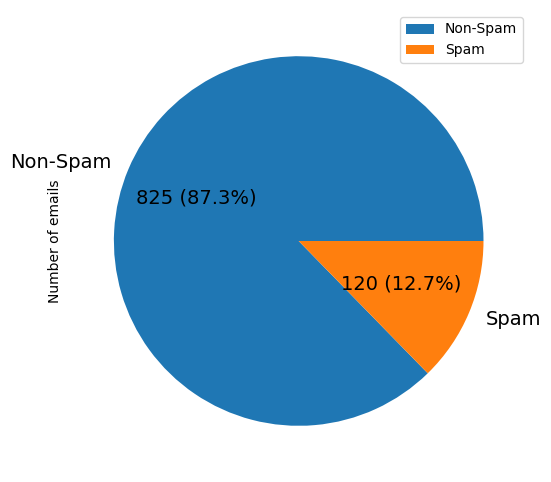

In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of emails': [data['label'].value_counts()[0], data['label'].value_counts()[1]]}
    df = pd.DataFrame(dataset_statistics, index=['Non-Spam', 'Spam'])
    df.plot(kind='pie', y='Number of emails', figsize=(6, 6), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))
    
# Raw data statistics
get_dataset_statistics(raw_train_data)

In [ ]:
raw_test_data = get_raw_data(dir_name + 'datasets/email_spam/', 'test')
raw_test_data

,text,label
0,"UpgrdCentre Orange customer, you may now claim...",1
1,"Loan for any purpose £500 - £75,000. Homeowner...",1
2,Congrats! Nokia 3650 video camera phone is you...,1
3,URGENT! Your Mobile number has been awarded wi...,1
4,Someone has contacted our dating service and e...,1
...,...,...
120,7 wonders in My WORLD 7th You 6th Ur style 5th...,0
121,Try to do something dear. You read something f...,0
122,Sun ah... Thk mayb can if dun have anythin on....,0
123,"SYMPTOMS when U are in love: ""1.U like listeni...",0


In [ ]:
raw_test_data['label'].value_counts()

1    76
0    49
Name: label, dtype: int64

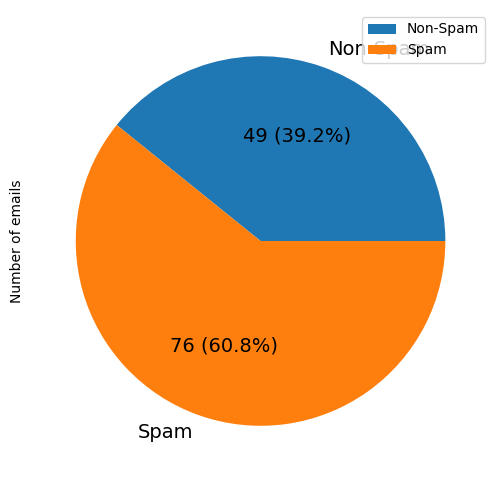

In [ ]:
get_dataset_statistics(raw_test_data)

# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def message_preprocessing(raw_message):
  message_words = raw_message.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(message_words.lower())
  filtered_message = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_message)

In [ ]:
train_data = raw_train_data[['text', 'label']].copy()

train_data['text'] = raw_train_data['text'].apply(message_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,rofl true,0
1,guy bitching acted like id interested buying w...,0
2,pity mood soany suggestions,0
3,ü b going esplanade fr home,0
4,2nd time tried 2 contact u u £750 pound prize ...,1
...,...,...
952,hows favourite person today r u workin hard sl...,0
953,got cleaning,0
954,sorry da gone mad pending works,0
955,wat time ü finish,0


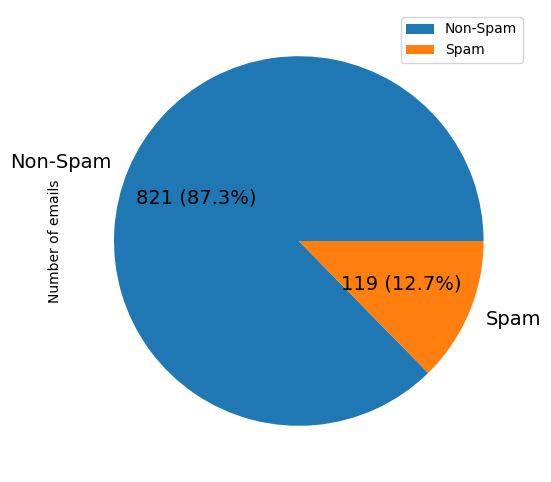

In [ ]:
get_dataset_statistics(train_data)

In [ ]:
test_data = raw_test_data[['text', 'label']].copy()

test_data['text'] = raw_test_data['text'].apply(message_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,upgrdcentre orange customer claim free camera ...,1
1,loan purpose £500 £75000 homeowners tenants we...,1
2,congrats nokia 3650 video camera phone 0906638...,1
3,urgent mobile number awarded £2000 prize guara...,1
4,contacted dating service entered phone fancy l...,1
...,...,...
120,7 wonders world 7th 6th ur style 5th ur smile ...,0
121,try dear read exams,0
122,sun ah thk mayb dun anythin thk book e lesson ...,0
123,symptoms u love 1u like listening songs 2u sto...,0


# Text Representation

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
ori_X_train = np.stack(np.array([get_text_vec(sms_text) for sms_text in train_data['text'].values]))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
ori_X_train.shape

(940, 300)

In [ ]:
X_test = np.stack(np.array([get_text_vec(sms_text) for sms_text in test_data['text'].values]))

In [ ]:
X_test.shape

(124, 300)

In [ ]:
ori_y_train = train_data['label'].values

In [ ]:
ori_y_train.shape

(940,)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(124,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2, average='binary')

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score', 'MCC'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0],
      results['split{}_test_MCC'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Email Spam/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score),
                                                                       'Precision': make_scorer(precision_score),
                                                                       'MCC' : make_scorer(matthews_corrcoef)
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    f1score = f1_score(test_labels, y_pred)
    f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')
    mcc = matthews_corrcoef(y_test, y_pred)

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print("MCC = {}".format(mcc))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score
    evaluation_metrics.loc[model_name, 'MCC'] = mcc

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        forest_param_grid = [{'n_estimators': [5,10,15,20,25], 'max_features': [10, 15, 20], 'min_samples_split': [15, 20, 25], 'criterion': ['gini','entropy'], 'max_depth': [5,6,7]}]
        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'kernel': ['rbf', 'poly'], 'degree': [2, 3 ,4, 5] }]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

## Random forest

In [ ]:
evaluation_metrics_orginal = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score', 'MCC'])

train accuracy = 0.9829787234042553
test accuracy = 0.75
Recall = 0.5866666666666667
Precision = 1.0
F1 score = 0.7394957983193278
F2 score = 0.6395348837209303
MCC = 0.5994441870043727
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        49
           1       1.00      0.59      0.74        75

    accuracy                           0.75       124
   macro avg       0.81      0.79      0.75       124
weighted avg       0.85      0.75      0.75       124



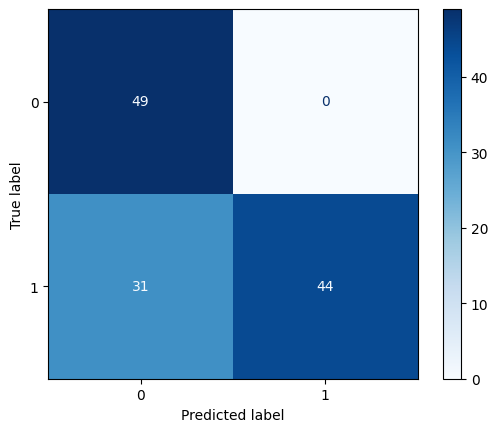

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 15, 'n_estimators': 10}


(0.7394957983193278, 0.6395348837209303)

In [ ]:
train(1, ori_X_train, ori_y_train, X_test, y_test, evaluation_metrics_orginal, to_save=True, file_name='OD_RF')

# SVM

train accuracy = 0.9861702127659574
test accuracy = 0.8709677419354839
Recall = 0.7866666666666666
Precision = 1.0
F1 score = 0.8805970149253731
F2 score = 0.8217270194986072
MCC = 0.7700815807598835
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        49
           1       1.00      0.79      0.88        75

    accuracy                           0.87       124
   macro avg       0.88      0.89      0.87       124
weighted avg       0.90      0.87      0.87       124



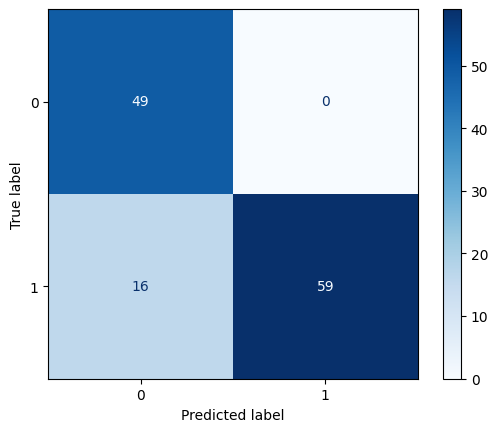

{'degree': 2, 'kernel': 'rbf'}


(0.8805970149253731, 0.8217270194986072)

In [ ]:
train(2, ori_X_train, ori_y_train, X_test, y_test, evaluation_metrics_orginal, to_save=True, file_name='OD_SVM')

#BiLSTM

In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import StratifiedKFold
seed = 221
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
text_words_lengths = [len(raw_train_data.loc[i]['text'].split()) for i in raw_train_data.index ]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))

In [ ]:
text_words_mean

15

In [ ]:
def create_blstm_model(sent_length, words_mean, train_texts):

  text_vec = layers.TextVectorization( 
    max_tokens=sent_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=words_mean
  )

  text_vec.adapt(train_texts)

  embedding_layer = layers.Embedding(
    input_dim=sent_length,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=words_mean
  )

  input_layer = layers.Input(shape=(1,), dtype=tf.string) 

  vec_layer = text_vec(input_layer)
  embedding_layer_model = embedding_layer(vec_layer) 

  bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer = L1L2(l1=0.01, l2=0.0)))(embedding_layer_model) 

  flatten = layers.Flatten()(bi_lstm) 
  dropout = layers.Dropout(.1)(flatten) 

  x = layers.Dense(32, activation='relu')(dropout) 

  output_layer = layers.Dense(1, activation='sigmoid')(x) 

  blstm_model = keras.Model(input_layer, output_layer) 

  blstm_model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])  
  
  return blstm_model

# Cross Validation

In [ ]:
def cv_blstm(sent_length, words_mean):

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = train_data['text'].values
  Y = train_data['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(sent_length, words_mean, train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=16,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))

    f1_sc = f1_score(test_labels, y_pred)
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='binary')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm(total_length, text_words_mean)

Fold 0
Epoch 1/10
53/53 [==============================] - 19s 176ms/step - loss: 26.8970 - accuracy: 0.8806 - val_loss: 14.1451 - val_accuracy: 0.8936
Epoch 2/10
53/53 [==============================] - 4s 71ms/step - loss: 6.6189 - accuracy: 0.9728 - val_loss: 1.5234 - val_accuracy: 0.9574
Epoch 3/10
53/53 [==============================] - 2s 37ms/step - loss: 0.4707 - accuracy: 0.9905 - val_loss: 0.5191 - val_accuracy: 0.9574
Epoch 4/10
53/53 [==============================] - 1s 27ms/step - loss: 0.2831 - accuracy: 0.9953 - val_loss: 0.2422 - val_accuracy: 0.9574
Epoch 5/10
53/53 [==============================] - 1s 23ms/step - loss: 0.1487 - accuracy: 0.9965 - val_loss: 0.3546 - val_accuracy: 0.9468
Epoch 6/10
53/53 [==============================] - 1s 11ms/step - loss: 0.1173 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9681
Epoch 7/10
53/53 [==============================] - 1s 15ms/step - loss: 0.0884 - accuracy: 1.0000 - val_loss: 0.1938 - val_accuracy: 0.9574
Ep

3/3 [==============================] - 1s 7ms/step
Fold 5
Epoch 1/10
53/53 [==============================] - 10s 120ms/step - loss: 26.7937 - accuracy: 0.9019 - val_loss: 14.1316 - val_accuracy: 0.9468
Epoch 2/10
53/53 [==============================] - 3s 51ms/step - loss: 6.6223 - accuracy: 0.9799 - val_loss: 1.7478 - val_accuracy: 0.9149
Epoch 3/10
53/53 [==============================] - 2s 26ms/step - loss: 0.4709 - accuracy: 0.9917 - val_loss: 0.5198 - val_accuracy: 0.8936
Epoch 4/10
53/53 [==============================] - 1s 13ms/step - loss: 0.1522 - accuracy: 0.9965 - val_loss: 1.1834 - val_accuracy: 0.9149
Epoch 5/10
53/53 [==============================] - 1s 19ms/step - loss: 0.2338 - accuracy: 0.9976 - val_loss: 0.3389 - val_accuracy: 0.9255
Epoch 6/10
53/53 [==============================] - 1s 21ms/step - loss: 0.1067 - accuracy: 1.0000 - val_loss: 0.3190 - val_accuracy: 0.9468
Epoch 7/10
53/53 [==============================] - 1s 13ms/step - loss: 0.0874 - accuracy: 

3/3 [==============================] - 1s 5ms/step
Fold 6
Epoch 1/10
53/53 [==============================] - 10s 118ms/step - loss: 26.7031 - accuracy: 0.8771 - val_loss: 13.9479 - val_accuracy: 0.9255
Epoch 2/10
53/53 [==============================] - 3s 47ms/step - loss: 6.5608 - accuracy: 0.9740 - val_loss: 1.4692 - val_accuracy: 0.9787
Epoch 3/10
53/53 [==============================] - 1s 27ms/step - loss: 0.4523 - accuracy: 0.9941 - val_loss: 0.4163 - val_accuracy: 0.9894
Epoch 4/10
53/53 [==============================] - 1s 13ms/step - loss: 0.1749 - accuracy: 0.9965 - val_loss: 0.1956 - val_accuracy: 0.9787
Epoch 5/10
53/53 [==============================] - 1s 18ms/step - loss: 0.1074 - accuracy: 1.0000 - val_loss: 0.1260 - val_accuracy: 0.9894
Epoch 6/10
53/53 [==============================] - 1s 13ms/step - loss: 0.0909 - accuracy: 1.0000 - val_loss: 0.8007 - val_accuracy: 0.8191
Epoch 7/10
53/53 [==============================] - 1s 14ms/step - loss: 0.2347 - accuracy: 

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,0.909091,0.5,0.645161,0.78125
1,1.0,0.8,0.888889,0.952381
2,0.333333,1.0,0.5,0.384615
3,0.666667,0.8,0.727273,0.689655
4,0.916667,0.916667,0.916667,0.916667
5,0.583333,0.875,0.7,0.625
6,1.0,1.0,1.0,1.0
7,0.833333,0.909091,0.869565,0.847458
8,0.916667,0.916667,0.916667,0.916667
9,0.833333,0.909091,0.869565,0.847458


In [ ]:
cv_results.mean()

Recall       0.799242
Precision    0.862652
F1 score     0.803379
F2 score     0.796115
dtype: float64

In [ ]:
def train_blstm(sent_length, words_mean, train_texts, train_labels):

  blstm_model = create_blstm_model(sent_length, words_mean, train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(X_test, y_test))
  
  blstm_model.evaluate(X_test, y_test)
  y_pred = np.round(blstm_model.predict(X_test))

  f1_sc = f1_score(y_test, y_pred)
  f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')
  mcc = matthews_corrcoef(y_test, y_pred)


  print("test accuracy = " + str(accuracy_score(y_test, y_pred)))
  print("Recall = {}".format(recall_score(y_test, y_pred)))
  print("Precision = {}".format(precision_score(y_test, y_pred)))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print("MCC = {}".format(mcc))
  print(classification_report(y_test, y_pred))
  
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc


In [ ]:
X_train = train_data['text'].values

In [ ]:
X_train.shape

(940,)

In [ ]:
y_train = train_data['label'].values.reshape(-1, 1)

In [ ]:
y_train.shape

(940, 1)

In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

Epoch 1/10
59/59 [==============================] - 10s 104ms/step - loss: 31.0245 - accuracy: 0.8936 - val_loss: 11.7669 - val_accuracy: 0.8790
Epoch 2/10
59/59 [==============================] - 2s 41ms/step - loss: 3.6894 - accuracy: 0.9766 - val_loss: 0.7720 - val_accuracy: 0.8548
Epoch 3/10
59/59 [==============================] - 1s 22ms/step - loss: 0.3081 - accuracy: 0.9926 - val_loss: 0.4842 - val_accuracy: 0.8710
Epoch 4/10
59/59 [==============================] - 1s 15ms/step - loss: 0.2134 - accuracy: 0.9957 - val_loss: 1.4391 - val_accuracy: 0.7742
Epoch 5/10
59/59 [==============================] - 1s 26ms/step - loss: 0.1785 - accuracy: 0.9989 - val_loss: 3.6133 - val_accuracy: 0.6694
Epoch 6/10
59/59 [==============================] - 1s 14ms/step - loss: 0.1951 - accuracy: 0.9947 - val_loss: 1.9707 - val_accuracy: 0.7742
Epoch 7/10
59/59 [==============================] - 1s 16ms/step - loss: 0.1607 - accuracy: 1.0000 - val_loss: 0.5598 - val_accuracy: 0.8710
Epoch 8/1

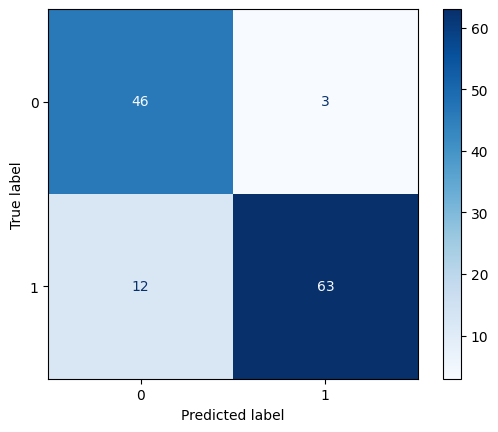

0.8936170212765958

In [ ]:
train_blstm(total_length, text_words_mean, X_train, y_train)